In [1]:
import os
import pandas as pd
import numpy as np
import torch
import tensorflow as tf # Use tf to read images because Pillow causes problems
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Path to INbreast folder containing INbreast.xls and an 'images' folder
# with all DICOM images converted to PNG
PATH = 'INbreast'

# Create DataFrames

In [3]:
test_list = [ f for f in os.listdir(PATH+"/images")]
test_list.sort()
len(test_list)

410

In [4]:
# Create lists for pandas df
fname = []
patients = []
views = []
sides = []

for i in range(len(test_list)):
    l = test_list[i].split("_")
    fname.append(l[0])
    patients.append(l[1])
    sides.append(l[3])
    views.append(l[4])

df = pd.DataFrame(list(zip(fname, patients, sides, views, test_list)), 
                  columns=['image_id', 'patient_id', 'side', 'view', 'filename'])

In [5]:
df_xls = pd.read_excel(
    PATH + "/INbreast.xls", 
    dtype={'File Name': str}, 
    usecols=["File Name", "Bi-Rads", "Acquisition date", "Laterality", "View"])
df_xls = df_xls.rename(columns={"File Name": "image_id", "Acquisition date": "date"})

In [6]:
# Add 'label' columns from BI-RADS categories

label = []
for index, row in df_xls.iterrows():
    birads = row["Bi-Rads"]
    if (type(birads) is str):
        birads = int(birads[0])
    if (birads == 1 or birads == 2):
        label.append(0)
    elif (birads == 3):
        label.append(-1)
    else:
        label.append(1)
    
df_xls["label"] = label

In [7]:
# Merge the two dataframes
merged_df = pd.merge(df, df_xls, how='left', on=['image_id'])
merged_df = merged_df.filter(["image_id", "patient_id", "side", "View", "filename", "date", "Bi-Rads","label"])
merged_df = merged_df.rename(columns={"View": "view", "Bi-rads": "birads"})
merged_df = merged_df.sort_values(by=["patient_id", "date", "side", "view"])
merged_df = merged_df[merged_df.view.isin(["CC", "MLO"])]
len(merged_df)

409

In [8]:
# Handle cases of same patient with multiple exams (different dates)
# + remove cases that don't have two views
# + if num_views = 4, remove cases that don't have 4 views
# + remove label=-1 aka birads=3

def clean_df(df, num_views=2):    
    grouped = df.groupby(["patient_id", "side", "view"])
    for name, group in grouped:
        # if there is more than 1 date
        if len(set(group["date"])) > 1:
            date_max = max(group["date"])
            df = df.drop(group[group.date != date_max].index)
            
        # if there isn't more than 1 date but there are still multiple images
        # aka there is a duplicate
        elif len(group) > 1:
            df = df.drop(list(group.index)[-1])

    grouped = df.groupby(["patient_id", "side"])
    for name, group in grouped:
        if len(group) < 2:
            df = df.drop(index=group.index)
    
    df = df[df.label.isin([0, 1])]
    
    if num_views == 4:
        grouped = df.groupby(["patient_id", "view"])
        for name, group in grouped:
            if (len(group) < 2):
                df = df.drop(index=group.index)
    
    df = df.sort_values(by=["patient_id", "side", "view"])
    df = df.reset_index(drop=True)
    return df

In [9]:
two_views_df = clean_df(merged_df, num_views=2)
four_views_df = clean_df(merged_df, num_views=4)
len(two_views_df), len(four_views_df)

(352, 296)

In [10]:
# Save dataframes
# two_views_df.to_pickle(f"{PATH}/two_views_df.pkl")
# four_views_df.to_pickle(f"{PATH}/four_views_df.pkl")

# Create splits

In [11]:
SEED = 42
NUM_VIEWS = 2
assert NUM_VIEWS in [2, 4]

In [12]:
# Define/load dataframe

if NUM_VIEWS == 2:
    df = two_views_df
    # df = pd.read_pickle(f"{SAVE_PATH}/two_views_df.pkl")
else:
    df = four_views_df
    # df = pd.read_pickle(f"{SAVE_PATH}/four_views_df.pkl")
    
len(df)

352

In [13]:
if NUM_VIEWS == 2:
    X, y = [], []
    grouped = df.groupby(["patient_id", "side"])
    for name, group in grouped:
        X.append(name[0] + "_" + name[1])
        y.append(list(group['label'])[0])
else:
    X = df.patient_id.unique().tolist()

In [14]:
if NUM_VIEWS == 2:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)
else:
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=SEED)

# Load data

In [15]:
# Read and resize image
def get_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img)
    img = tf.image.resize(img, (600, 500))
    img = np.asarray(img).squeeze()
    return img

# Load all data into memory (for faster training)
def load_data(images_path, pat_list, df, num_views):
    data = []
    pos = 0
    
    for elem in pat_list:
        if num_views == 2:
            pat_id, side = elem.split("_")
            pat_df = df[(df.patient_id==pat_id) & (df.side==side)]
        else:
            pat_id = elem
            pat_df = df[df.patient_id==pat_id]
        

        cc_name = pat_df.loc[pat_df.view=='CC', 'filename'].tolist()
        mlo_name = pat_df.loc[pat_df.view=='MLO', 'filename'].tolist()
        
        cc_image = get_image(images_path + '/' + cc_name[0])
        mlo_image = get_image(images_path + '/' + mlo_name[0])
        
        if num_views == 2:
            image = np.stack([cc_image, mlo_image])
            label = pat_df['label'].tolist()[0]
            
            if label == 1:
                pos += 1
        else:
            r_cc_image = np.flip(get_image(images_path + '/' + cc_name[1]), axis=1)
            r_mlo_image = np.flip(get_image(images_path + '/' + mlo_name[1]), axis=1)
            image = np.stack((cc_image, mlo_image, r_cc_image, r_mlo_image))
            
            label_sx = pat_df['label'].tolist()[0] 
            label_dx = pat_df['label'].tolist()[2]
            label = (label_sx, label_dx)
            
            if label_sx == 1:
                pos += 1

            if label_dx == 1:
                pos += 1
        
        data.append([torch.FloatTensor(image), label])
        
    return data, pos

def plot_exam(exam, num_views):
    print("Images have shape: ", exam.shape)
    fig, axes = plt.subplots(1, num_views)
    axes[0].imshow(exam[0, :, :], cmap="gray")
    axes[1].imshow(exam[1, :, :], cmap="gray")
    if num_views == 4:
        axes[2].imshow(exam[2, :, :], cmap="gray")
        axes[3].imshow(exam[3, :, :], cmap="gray")

In [16]:
train_data, pos = load_data(PATH+'/images', X_train, df, NUM_VIEWS)
test_data, vpos = load_data(PATH+'/images', X_test, df, NUM_VIEWS)

print("Len train: ", len(train_data))
print("Len test: ", len(test_data))
tot_train = len(train_data) if NUM_VIEWS == 2 else len(train_data)*2
tot_test = len(test_data) if NUM_VIEWS == 2 else len(test_data)*2
print(f"Train: pos {pos}, neg {tot_train - pos}")
print(f"Test: pos {vpos}, neg {tot_test - vpos}")

Len train:  123
Len test:  53
Train: pos 34, neg 89
Test: pos 14, neg 39


Images have shape:  torch.Size([2, 600, 500])


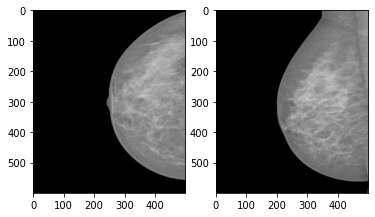

In [17]:
plot_exam(train_data[0][0], num_views=NUM_VIEWS)

Images have shape:  torch.Size([2, 600, 500])


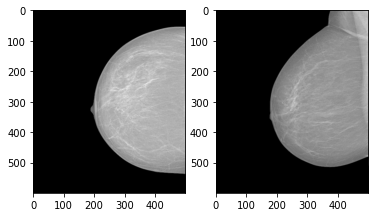

In [18]:
plot_exam(test_data[0][0], num_views=NUM_VIEWS)

In [19]:
# Save data
# torch.save(train_data, f"{PATH_SAVE}/training_{NUM_VIEWS}views.pt")    
# torch.save(test_data, f"{PATH_SAVE}/validation_{NUM_VIEWS}views.pt")